##Устанавливаем необходимые пакеты и библиотеки

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

In [3]:
BiocManager::install("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.14 (BiocManager 1.30.25), R 4.1.2 (2021-11-01)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘bit’, ‘bitops’, ‘formatR’, ‘bit64’, ‘blob’, ‘plogr’, ‘png’, ‘Biostrings’, ‘curl’, ‘openssl’, ‘colorspace’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘lambda.r’, ‘futile.options’, ‘DBI’, ‘RSQLite’, ‘KEGGREST’, ‘XML’, ‘httr’, ‘farver’, ‘labeling’, ‘munsell’, ‘viridisLite’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘AnnotationDbi’, ‘annotate’, ‘RColorBrewer’, ‘gtable’, ‘isoband’, ‘scales’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘ggplot2’, ‘RcppArmadillo’


Installation paths not

In [4]:
install.packages("pheatmap")

Installing package into ‘/home/auser/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [5]:
library("DESeq2")
library("pheatmap")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

##Считываем файл с чтениями в info и преобразуем в матрицу в counts

In [65]:
nrow(info)
ncol(counts)

[1] 6

[1] 6

In [64]:
counts <- as.matrix(read.table("ALL.counts", header=TRUE, sep = ","))
info   <- read.table("ALL(6).info", header=TRUE, sep = ",")

dds <- DESeqDataSetFromMatrix(countData = counts, colData = info, design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [66]:
head(info)

,q,id,condition
,<chr>,<chr>,<chr>
1,c1,SRR3414635,control
2,c2,SRR3414636,control
3,c3,SRR3414637,control
4,r1,SRR3414629,reprogramming
5,r2,SRR3414630,reprogramming
6,r3,SRR3414631,reprogramming


In [67]:
head(counts)

,c1,c2,c3,r1,r2,r3
ENSMUSG00000000001.4,3466,3532,4078,4507,3964,5757
ENSMUSG00000000003.15,0,0,0,0,0,0
ENSMUSG00000000028.15,152,137,152,348,275,472
ENSMUSG00000000031.16,55721,48392,56187,64722,33333,65188
ENSMUSG00000000037.17,43,44,53,79,70,92
ENSMUSG00000000049.11,10,8,11,4,1,1


##С помощью DESeq получаем в res таблицу с дифференуциально экспрессированными генами

In [68]:
# Tell the DDS which columns correspond to the 'reference' level of gene expression
dds$condition <- relevel(dds$condition, ref="control")

dds <- DESeq(dds)
res <- results(dds, alpha=0.01)   # Specify a more strict threshold on padj. This threshold is called 'alpha'


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



##Строим Heatmap для уровня экспрессии образцов и еще один график с дифференциально экспрессированными генами

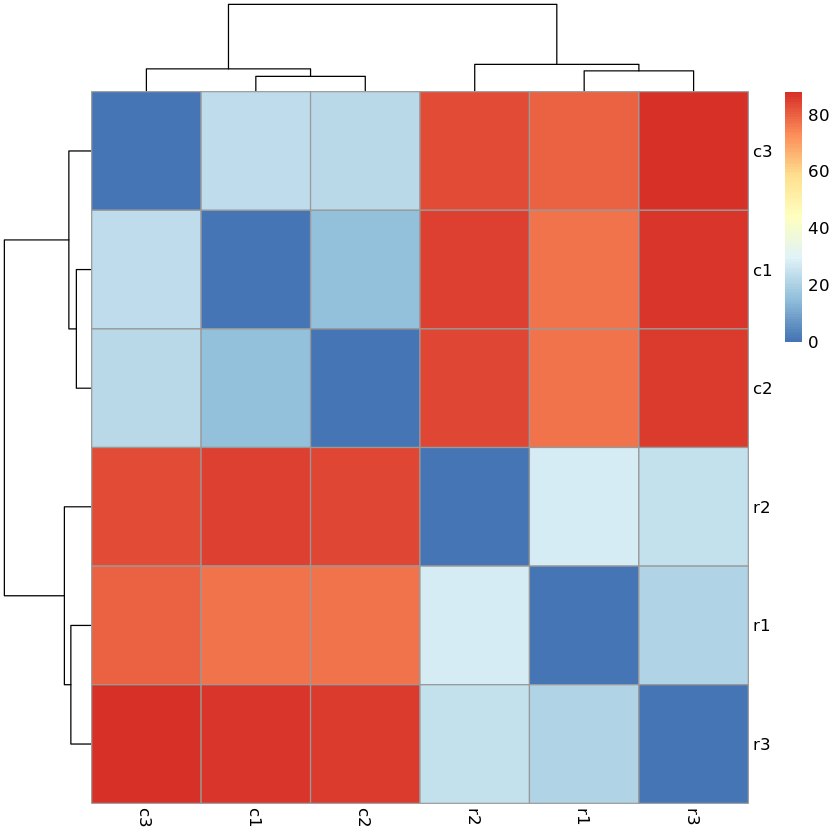

In [69]:
rld <- rlog(dds)
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists)


In [70]:
resOrdered <- res[order(res$padj),]
resSignificant <- subset(resOrdered, padj < 0.01)
write.table(resSignificant, "differentially_expressed_genes.txt", sep="\t", row.names=TRUE, quote = FALSE)

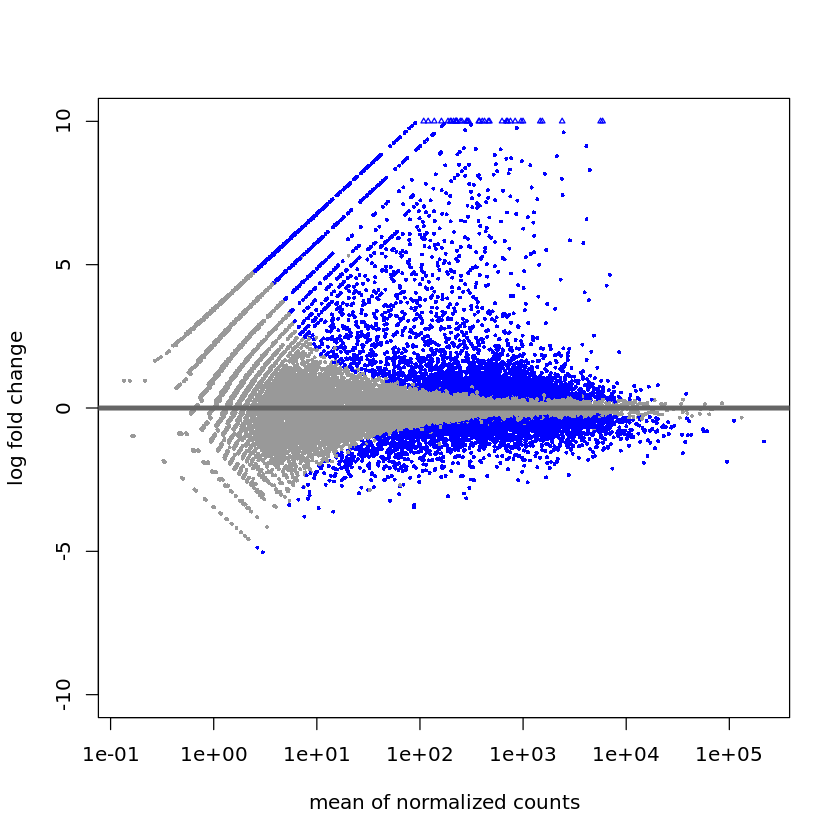

In [71]:
plotMA(res, ylim=c(-10,10))

##И еще один Heatmap с условиями для дифференциально экспрессированных генов

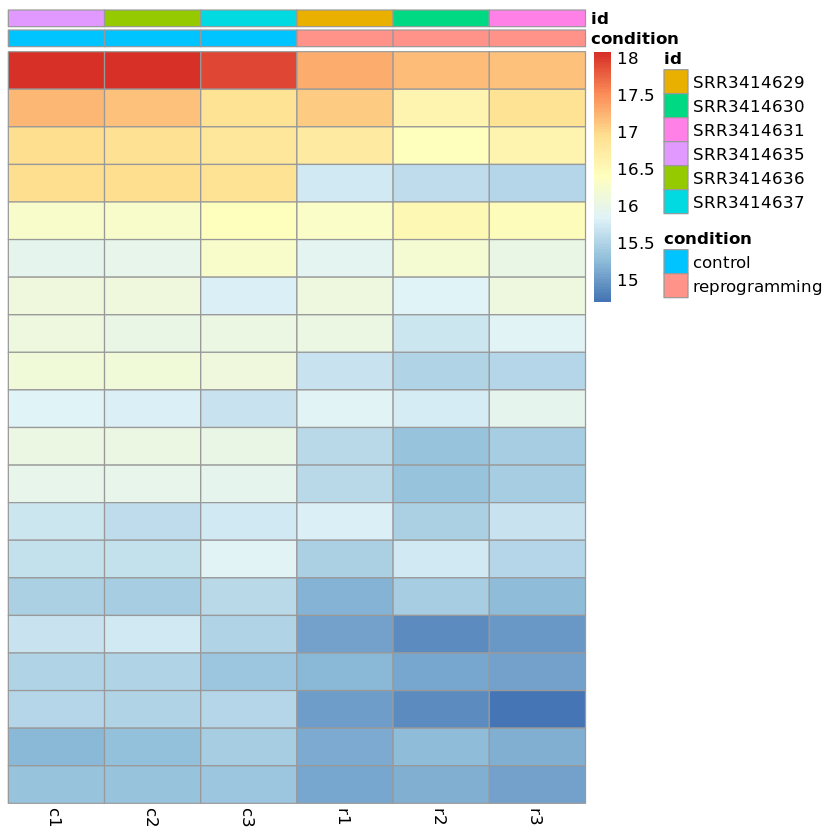

In [72]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("condition","id")])
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,cluster_cols=FALSE, annotation_col=df)


##И на графиках еще проверим, действительно ли гены являются дифференциально экспрессированными (отображаем два условия и смотрим на число счетов)

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
                      baseMean log2FoldChange     lfcSE      stat       pvalue
                     <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSMUSG00000035557.9   5647.17        11.8829  0.493665   24.0708 5.06065e-128
                             padj
                        <numeric>
ENSMUSG00000035557.9 2.05373e-125

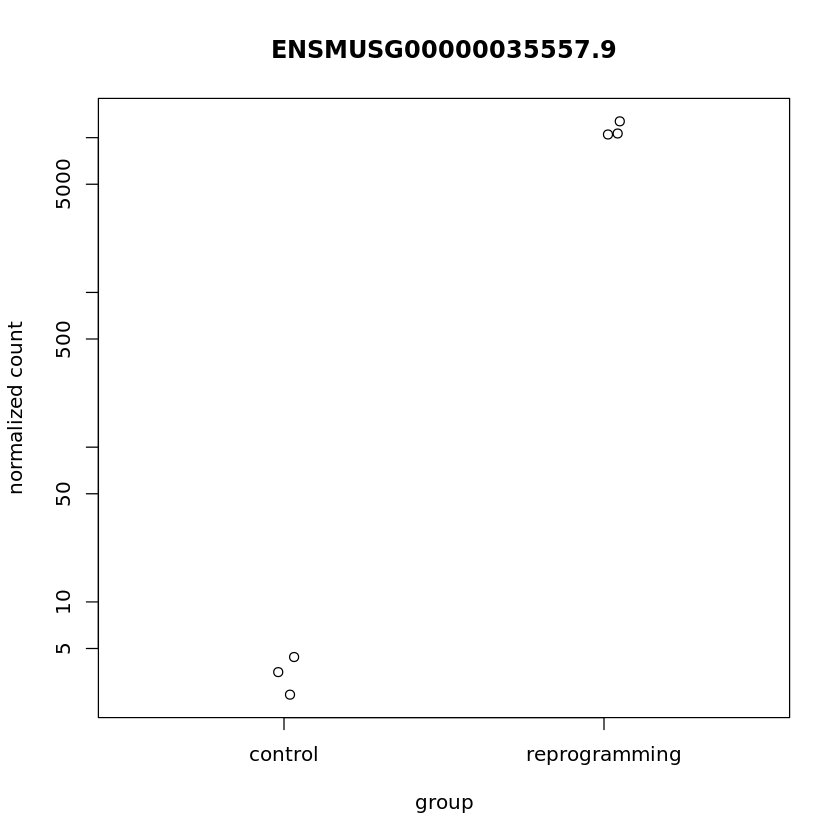

In [73]:
res[10072,]
plotCounts(dds, gene=10072, intgroup="condition")

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
                       baseMean log2FoldChange     lfcSE      stat      pvalue
                      <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000040728.15   422.308        12.1686   1.18742    10.248 1.20858e-24
                             padj
                        <numeric>
ENSMUSG00000040728.15 3.11507e-23

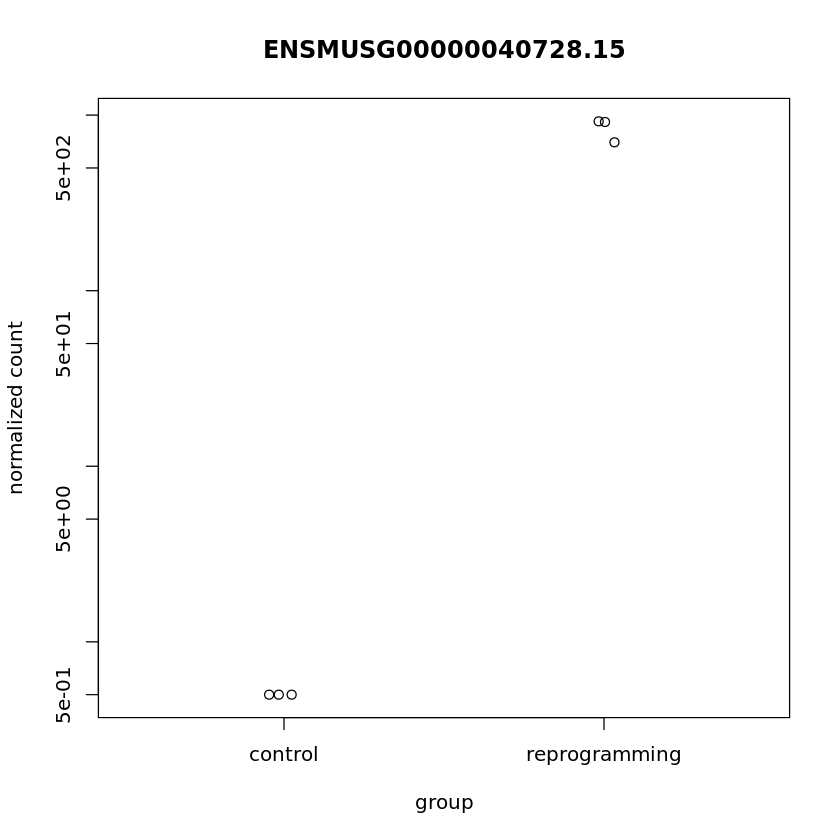

In [74]:
res[12032,]
plotCounts(dds, gene=12032, intgroup="condition")

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
                       baseMean log2FoldChange     lfcSE      stat      pvalue
                      <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000046180.11   297.237        11.6622   1.19426   9.76522 1.58762e-22
                             padj
                        <numeric>
ENSMUSG00000046180.11 3.62682e-21

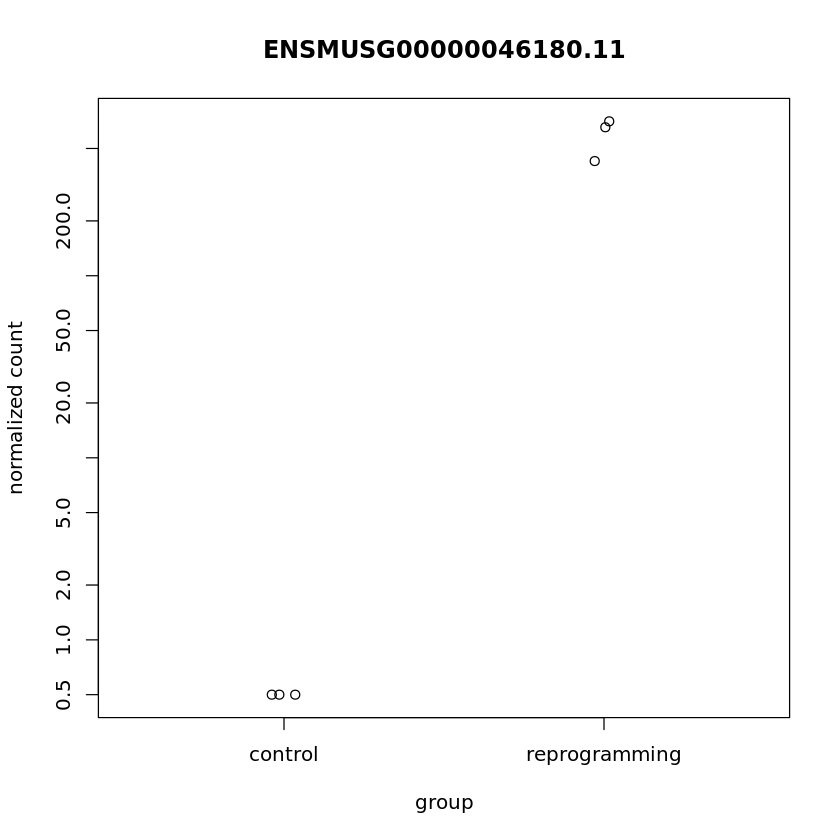

In [75]:
res[13630,]
plotCounts(dds, gene=13630, intgroup="condition")

В итоге видим, что получились сильно разбросанные точки у контрольных и перепрограммированых генов